In [22]:
# 4.4

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
# Allows plots generated by Matplotlib to be displayed directly within the notebook, instead of in a separate window.
from astropy.io import fits
from scipy import stats, optimize
from numpy.polynomial import Polynomial
# Allows the creation and manipulation of polynomials, perform polynomial fitting, and solve polynomial equations.
from astropy.visualization import ZScaleInterval
# This a method often used in astronomical image processing to stretch the contrast of an image for visualization. 
zscale=ZScaleInterval()
# It automatically determines a suitable brightness scale for the image by calculating the optimal range based on pixel distribution.
from scipy.signal import find_peaks
# To detect peaks in data, such as identifying emission or absorption lines in a spectrum by locating local maxima.

This section focuses on performing spectroscopic calibration using a 50 µm slit. The tasks include identifying the correct spectrum, collapsing the 2D flat-field into 1D, and normalizing the flat-field to correct for sensitivity variations. The normalization involves fitting a low-order polynomial to remove the effects of the lamp spectrum, after which the normalized flat-field is applied to the arc lamp spectrum. Wavelength calibration is derived by identifying emission lines, plotting pixel positions against known wavelengths, and fitting a polynomial to compute the wavelength solution. Finally, the calibrated spectrum is plotted, with key Neon lines labeled, and the spectrograph’s wavelength coverage and dispersion are determined.

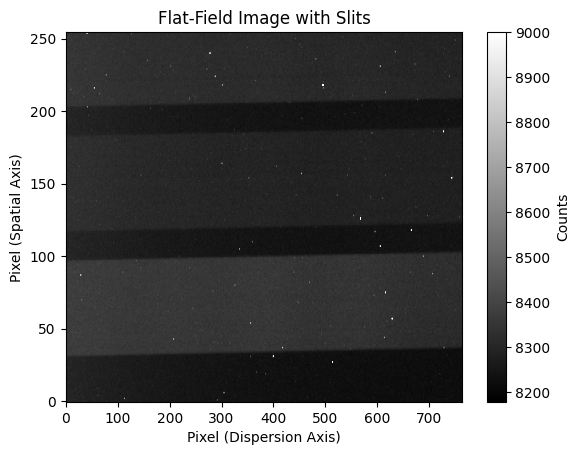

In [23]:
#4.4.1
flat_data = fits.getdata('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000003.FLAT.FIT')
# Extracts the 2D data from the first extension of the FITS file 


# Plot the image to inspect the spectra
plt.imshow(flat_data, cmap='gray', origin='lower', aspect='auto',vmax=9000)
plt.colorbar(label='Counts')
plt.title('Flat-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

The code above is designed to retrieve and visualize a flat-field image from a FITS file, which is crucial for calibrating spectrograph images. It starts by extracting the 2D data from the specified FITS file using `fits.getdata()`, allowing us to access the pixel values that represent the flat-field spectrum. The `vmax` parameter is set to 9000, capping the maximum value for the color scale, which helps in visualizing the data more effectively by emphasizing the significant features without saturating the image. Additionally, a color bar is included to indicate the counts corresponding to pixel values, and titles and axis labels are provided for context. The resulting plot allows for the inspection of the flat-field image, revealing the three distinct spectral bands associated with the three slits of varying widths (25 µm, 35 µm, and 50 µm). This visualization is essential for understanding the characteristics of the flat field, which is derived from known spectra, and aids in the subsequent calibration of the spectrograph images.

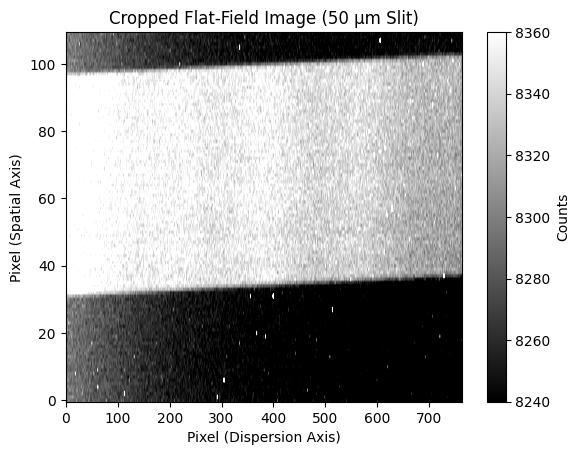

In [24]:
# Open the flat-field file
flat_field = fits.open('../FITS_Files/3.4_Spectropic_Flat_Fields_10_sec.00000000.FLAT.FIT')
flat_data = flat_field[0].data  # Extracts the 2D data from the first extension of the FITS file

# Define the row range for the 50 µm slit (adjust based on actual image)
# From the image, the 50 µm slit is in rows 0 to 110
row_start, row_end = 0, 110  
cropped_flat_field = flat_data[row_start:row_end, :]  # Keep all columns (dispersion axis)


# Plot the cropped image for the 50 µm slit
plt.imshow(cropped_flat_field, cmap='gray', origin='lower', aspect='auto', vmin=8240, vmax=8360)
plt.colorbar(label='Counts')
plt.title('Cropped Flat-Field Image (50 µm Slit)')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

This part is designed to extract and visualize a specific region of a flat-field image from a FITS file. The first step involves opening the flat-field FITS file using fits.open(), which allows access to the various extensions within the file. The 2D data from the first extension is then extracted and stored in the variable flat_data.

Next, the code defines a range of rows to isolate the data corresponding to the 50 µm slit. The cropped_flat_field variable stores the sliced data, retaining all columns (representing the dispersion axis) while limiting the rows to those that capture the area of interest.

The vmin and vmax parameters are set to be between 8240 and 8360, to enhance the best visibility of specific pixel count values within that range. This visualization allows for a focused examination of the flat-field data specific to the 50 µm slit, since this slit is the brightest and most clearly visible one, which is important for subsequent calibration and spectral data analysis. 

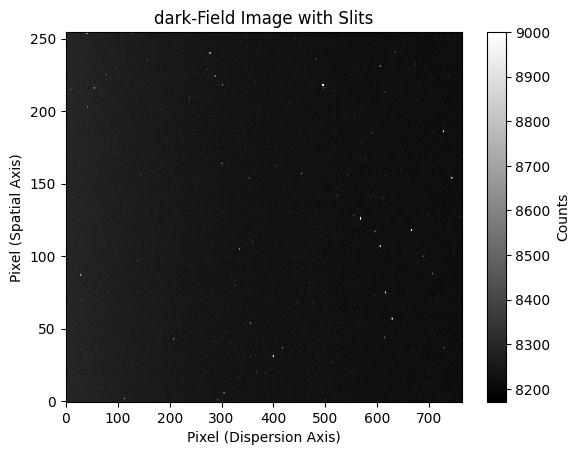

In [25]:
#4.4.1
dark_data = fits.getdata('../FITS_Files/3.4_Spectropic_Dark_Frame_10_sec.00000003.DARK.FIT')
# Extracts the 2D data from the first extension of the FITS file 


# Plot the image to inspect the spectra
plt.imshow(dark_data, cmap='gray', origin='lower', aspect='auto', vmax=9000)
plt.colorbar(label='Counts')
plt.title('dark-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

This code above extracts and visualizes a dark frame image from a FITS file, which represents the baseline signal of the detector without any light exposure. It uses fits.getdata() to retrieve the 2D pixel data from the specified dark frame file. The plt.imshow() function then displays the dark frame in grayscale, with the vmax parameter set to 9000 to enhance visibility. This visualization helps assess the quality of the dark frame for accurate subtraction during data calibration.

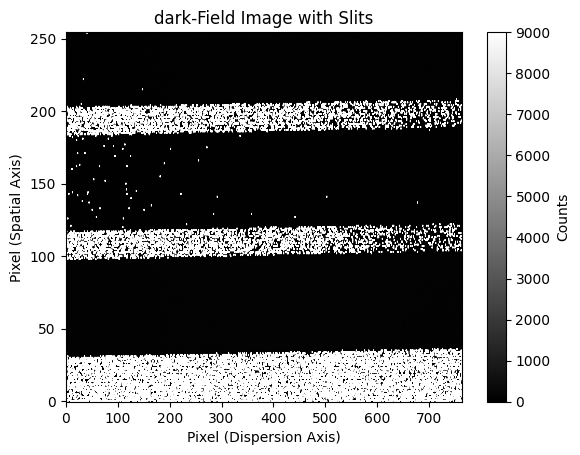

In [26]:
#4.4.1
dark_corrected_flat_data = flat_data-dark_data
# Extracts the 2D data from the first extension of the FITS file 


# Plot the image to inspect the spectra
plt.imshow(dark_corrected_flat_data, cmap='gray', origin='lower', aspect='auto', vmax=9000)
plt.colorbar(label='Counts')
plt.title('dark-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

This code subtracts the dark frame data from the flat-field data to create a dark-corrected flat-field image. The resulting image, `dark_corrected_flat_data`, is displayed using `plt.imshow()` in grayscale, with a maximum pixel value (`vmax`) set to 9000 for contrast. The plot includes axis labels and a color bar indicating pixel counts, allowing for inspection of the corrected data.

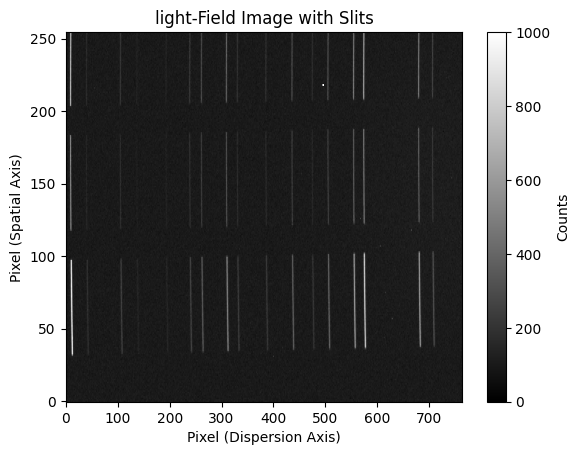

In [27]:
light_data = fits.getdata('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000001.FIT')
light_data_header=fits.getheader('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000001.FIT')
# Extracts the 2D data from the first extension of the FITS file 


# Plot the image to inspect the spectra
plt.imshow(light_data, cmap='gray', origin='lower', aspect='auto',vmax=1000)
plt.colorbar(label='Counts')
plt.title('light-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()

#The max is only 4000, which means the light frame is auto-darkened, the dark is already being subtracted from the light


The output above loads the light frame data from a FITS file and retrieves its header information, and displays the light field image in grayscale, setting a maximum pixel value (`vmax`) of 1000 for better contrast. The plot includes axis labels and a color bar indicating pixel counts. Maximum pixel value is only 4000 suggests that any dark signal has already been subtracted from the light frame, implying the data is auto-darkened. The output helps to compare the visibility and characteristics of the spectrum in 25, 35 and 50 micrometers, and shows that the spectrum of 50 micrometer is the best visible spectrum.

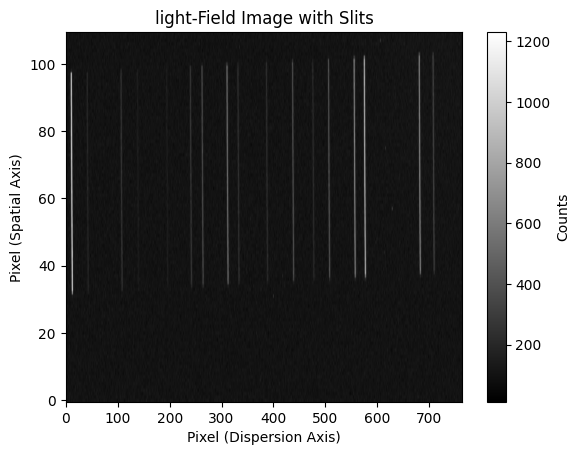

In [28]:
light_data = fits.getdata('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000001.FIT')
light_data_header=fits.getheader('../FITS_Files/3.4_Spectropic_Neon_10_sec.00000001.FIT')
# Extracts the 2D data from the first extension of the FITS file 

row_start, row_end = 0, 110  # You may need to fine-tune these values
cropped_light_field = light_data[row_start:row_end, :]  # Keep all columns (dispersion axis)

# Plot the image to inspect the spectra
plt.imshow(cropped_light_field, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Counts')
plt.title('light-Field Image with Slits')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Pixel (Spatial Axis)')
plt.show()


This code above is designed to load and visualize a cropped portion of the neon arc lamp spectrum obtained from a FITS file. The image is cropped vertically (from rows 0 to 110) to focus on the region corresponding to the 50 µm slit. The cropped data is then displayed using a grayscale color map, providing a clear view of the spectral features along the dispersion axis. The purpose of this is to prepare the neon spectrum for further analysis, such as applying flat-field correction, collapsing the data into a 1D spectrum, and eventually identifying emission lines for wavelength calibration.

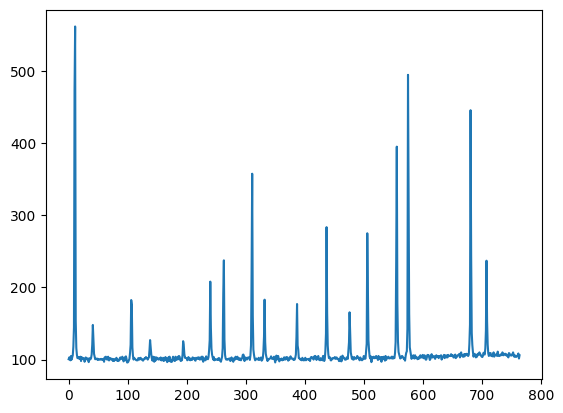

In [29]:
cropped_light_field_1D=np.median(cropped_light_field,axis=0)
plt.plot(cropped_light_field_1D)

The code above calculates the median intensity of the cropped 2D light field (neon arc lamp spectrum) along the spatial axis (rows) to collapse the data into a 1D spectrum. The output represents the median intensity at each pixel position along the dispersion axis (columns), providing a 1D profile of the arc lamp spectrum, and then generates a plot of this 1D spectrum.

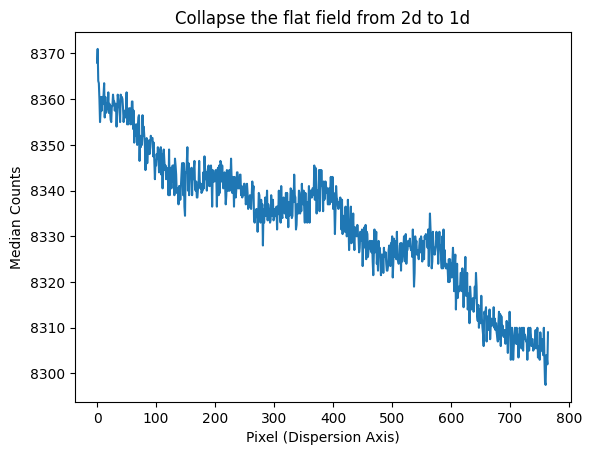

In [30]:
#4.4.2
#Crop data
cropped_flat_field_1D=np.median(cropped_flat_field,axis=0)
plt.plot(cropped_flat_field_1D)
plt.title('Collapse the flat field from 2d to 1d')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Median Counts')
plt.show()

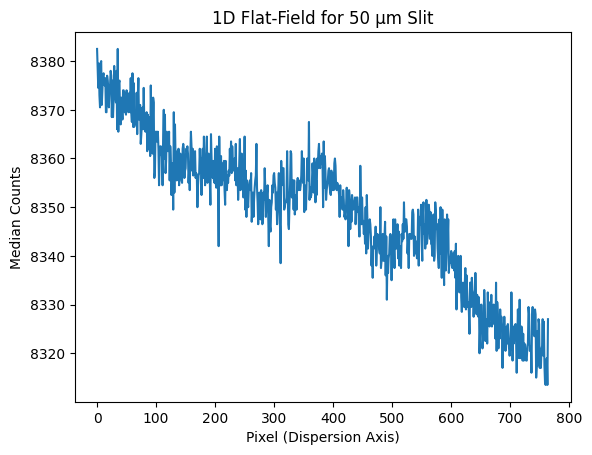

In [31]:
#4.4.2
# Define row range for the 50 µm slit (based on the previous plot)
row_start, row_end = 60,80 

# Extract the data for the 50 µm slit
slit_flat_data = flat_data[row_start:row_end, :]
# Slices the 2D array flat_data to only include rows between row_start and row_end 
# (corresponding to the 50 µm slit) while keeping all columns (dispersion axis).

# Takes the median of each column (along the spatial axis),
# collapse the 2D image to a 1D array where each element represents the median value of each column.
flat_1d = np.median(slit_flat_data, axis=0)

# Plot the 1D flat-field values against pixel positions
plt.plot(flat_1d)
plt.title('1D Flat-Field for 50 µm Slit')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Median Counts')
plt.show()
#This one is for the flat field

The code collapses the 2D flat-field data for the 50 µm slit into a 1D profile by calculating the median value of each column along the spatial axis. This step reduces the flat-field image to a single line representing the median counts at each pixel position along the dispersion axis. The plot of the 1D flat-field data reveals variations in sensitivity across the spectrum, helping identify regions with higher or lower counts. These insights are crucial for understanding and correcting the spectral response, improving the accuracy of the calibration.

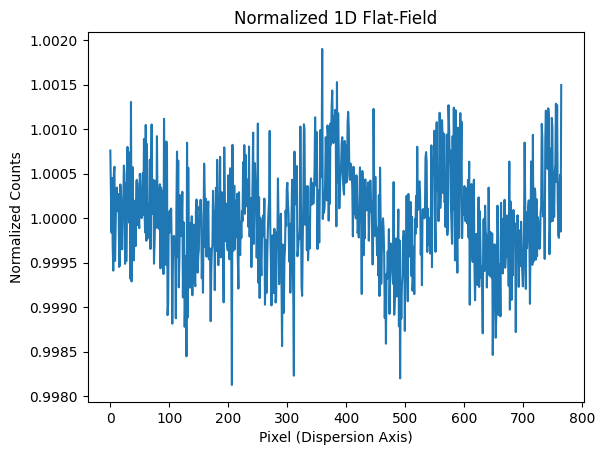

In [32]:
#4.4.3
# Fit a low-order polynomial to the 1D flat-field data
p = Polynomial.fit(np.arange(len(flat_1d)), flat_1d, deg=3)
# np.arange(len(flat_1d)): Generates an array of pixel positions (indices).

# Evaluate the polynomial to get the fit values
fit_values = p(np.arange(len(flat_1d)))

# Normalize the 1D flat-field by dividing by the fit
normalized_flat_1d = flat_1d / fit_values

# Plot the normalized 1D flat-field
plt.plot(normalized_flat_1d)
plt.title('Normalized 1D Flat-Field')
plt.xlabel('Pixel (Dispersion Axis)')
plt.ylabel('Normalized Counts')
plt.show()

The code normalizes the 1D flat-field data to correct for sensitivity variations along the dispersion axis. First, it fits a low-order polynomial to the 1D flat-field data, which models the expected response of the spectrograph. This fit smooths out the broader sensitivity variations across the spectrum. Then, by dividing the original flat-field data by the polynomial fit, the resulting normalized data fluctuates around a value of one, allowing for more accurate interpretation of remaining variations as real sensitivity differences. The final plot shows the normalized 1D flat-field, ensuring the correction is effective.

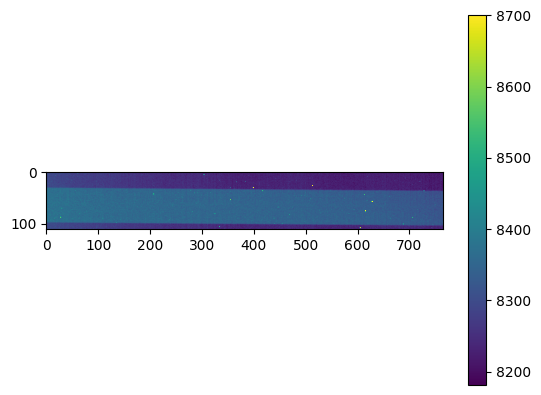

In [33]:
compare=cropped_flat_field/normalized_flat_1d
#Master dark frame ?
plt.imshow(compare, vmax=8700)
plt.colorbar()

The code compares the 2D cropped flat-field data to the normalized 1D flat-field by dividing the former by the latter. This creates a 2D array where each pixel in the cropped flat field is divided by the corresponding value in the normalized 1D flat-field. The result is then displayed as an image, where the vmax=8700 sets an upper limit for the intensity scaling in the plot. This process helps assess how well the normalization has worked by ensuring that the variations due to sensitivity have been minimized, leaving behind a more consistent, evenly distributed flat-field correction. This prepares the data for further calibration, like applying it to the arc lamp spectrum.

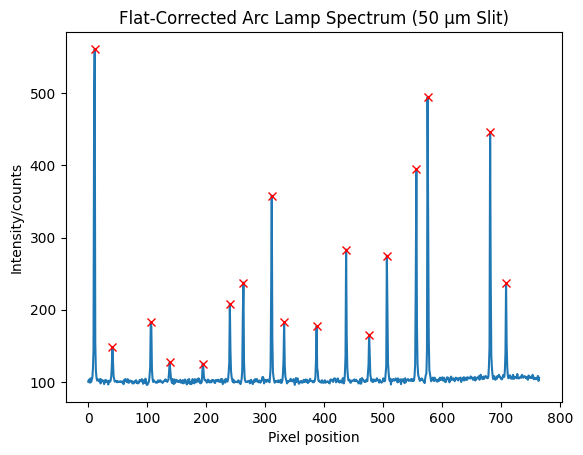

In [34]:
#4.4.4

#divide the arc lamp spectra by the normalized flat field


# Apply the normalized flat-field to the arc lamp spectrum
flat_corrected_arc = cropped_light_field_1D / normalized_flat_1d

# Plot the flat-corrected arc spectrum
plt.plot(flat_corrected_arc)

peak_idxs = find_peaks(flat_corrected_arc, height=112)

plt.plot(peak_idxs[0],flat_corrected_arc[peak_idxs[0]], 'rx' )

plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
plt.xlabel('Pixel position')
plt.ylabel('Intensity/counts')
plt.show()

The code applies the normalized flat-field correction to the arc lamp spectrum for the 50 µm slit. First, it divides the previously collapsed 1D arc lamp spectrum (`cropped_light_field_1D`) by the normalized flat-field data (`normalized_flat_1d`). This division corrects for sensitivity variations in the spectrograph, ensuring that the intensity values reflect true spectral features. 

The resulting flat-corrected arc spectrum is then plotted to visualize the corrected intensity against pixel positions. Peaks in the spectrum are identified using the `find_peaks` function from the `scipy.signal` module, with a height threshold set to 112 counts. This threshold helps to distinguish significant peaks from noise, allowing for effective analysis of the arc lamp spectrum. The identified peaks are marked on the plot with red crosses, facilitating visual identification of key spectral features after correction.

In [35]:
# 4.4.5
print(peak_idxs[0], 
      [585.24,588.34,594.54,597.64,607.38,
       609.6,614.26,616.46,621.56,626.66,630.42,
       633.52,638.18,640.18,650.58,653.24]) #flat_corrected_arc[peak_idxs[0]])

[ 11  41 106 138 194 240 263 311 332 387 437 476 506 556 575 681 708] [585.24, 588.34, 594.54, 597.64, 607.38, 609.6, 614.26, 616.46, 621.56, 626.66, 630.42, 633.52, 638.18, 640.18, 650.58, 653.24]


These are the pixel positions of the emission lines I see 

![Screenshot (466).png](<attachment:Screenshot (466).png>)

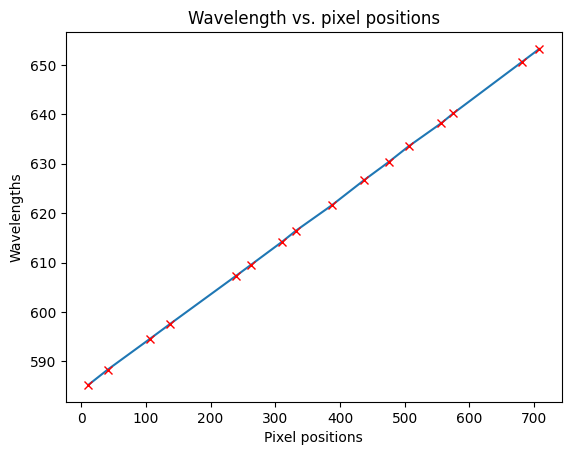

In [36]:
# 4.4.5
x_values = [11,41,106,138,240,263,311,332,387,437,476,506,556,575,681,708]
y_values = [585.24,588.34,594.54,597.64,607.38,609.6,614.26,616.46,621.56,626.66,630.42,633.52,638.16,640.18,650.58,653.24]

# Plotting the curve
plt.plot(x_values, y_values)
plt.plot(x_values, y_values,'rx')
plt.xlabel('Pixel positions')
plt.ylabel('Wavelengths')
plt.title('Wavelength vs. pixel positions')
plt.show()

In [37]:
slope,intercept = np.polyfit(x_values,y_values,1)
print('y=',slope,'x +',intercept)

y= 0.09738831013983289 x + 584.1277641945901


The code creates a plot showing the relationship between pixel positions and corresponding wavelengths, based on the list of pixel positions (x axis) with respect to the wavelengths (y axis) in nm. The plot includes both a line connecting the data points and individual data points marked with red crosses.

The resulting graph demonstrates a generally linear relationship between the pixel positions and wavelengths, with some scattering of data points indicating slight variations in the spacing between pixel positions. Despite this scatter, the overall trend remains linear enough to establish a reliable conversion factor for translating pixel positions into wavelengths. The parameters derived from this relationship—a y-intercept of 584.13 nm and a slope of 0.097 nm—can be used for wavelength calibration of the identified spectral features in subsequent analysis

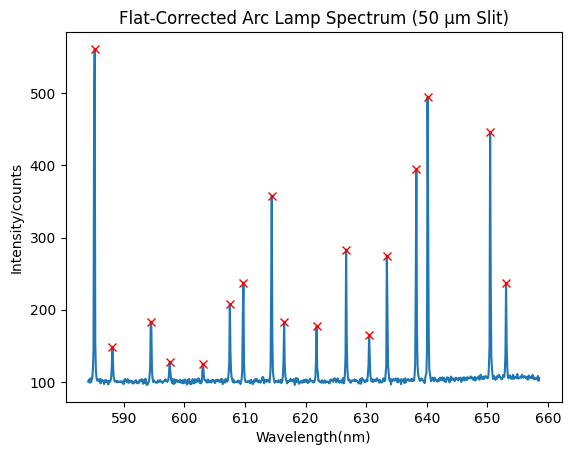

The wavelength ranges approximately from 584.1277641945901 nm to 658.5324331414224 nm, which is approximately 74.40466894683232 nm, or 744.0466894683232 Angstrom


In [38]:
# 4.4.6 

wavelengths=slope*np.arange(len(flat_corrected_arc))+intercept
# Plot the flat-corrected arc spectrum
# peak_idxs = find_peaks(flat_corrected_arc, threshold = 6)
# peak=find_peaks(flat_corrected_arc,threshold=6)
plt.plot(wavelengths,flat_corrected_arc)

peaks, _ = find_peaks(flat_corrected_arc, height=112)  # Adjust the 'height' parameter as necessary

# Mark the peaks with an 'x' symbol
plt.plot(wavelengths[peaks], flat_corrected_arc[peaks], 'x', color='red', label="Detected Peaks")

plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
plt.xlabel('Wavelength(nm)')
plt.ylabel('Intensity/counts')
plt.show()

# Compute the range of wavelengths
min_wavelength = min(wavelengths)
max_wavelength = max(wavelengths)
range=max_wavelength-min_wavelength

# Print the range of wavelengths
print(f"The wavelength ranges approximately from {min_wavelength} nm to {max_wavelength} nm, which is approximately",range,"nm, or",range*10,'Angstrom')

Here, the code above converts the x-axis of the flat-corrected arc lamp spectrum from pixel positions to wavelengths in nanometers using a linear conversion formula defined by a slope and an intercept obtained from previous analyses. 

The code above calculates the range of wavelengths from the wavelength array derived from the linear fit model. This range is then converted from nm to Angstroms by multiplying by 10, as 1 nanometer equals 10 Angstroms.

After calculating the wavelengths array using the formula, the code plots the flat-corrected arc spectrum, with the y-axis representing intensity counts. The peaks in the spectrum are identified using the find_peaks function, which locates significant intensity values above a specified threshold. These detected peaks are then marked on the plot with red 'x' symbols for easy visual identification.

The code also computes the range of wavelengths covered by the spectrum by finding the minimum and maximum values in the wavelengths array and printing the results. This provides insight into the spectral coverage of the observations, indicating the extent of the wavelengths analyzed and their conversion to Angstroms for further clarity.

Length of the spectrum covered by the spectrograph: 765 nm


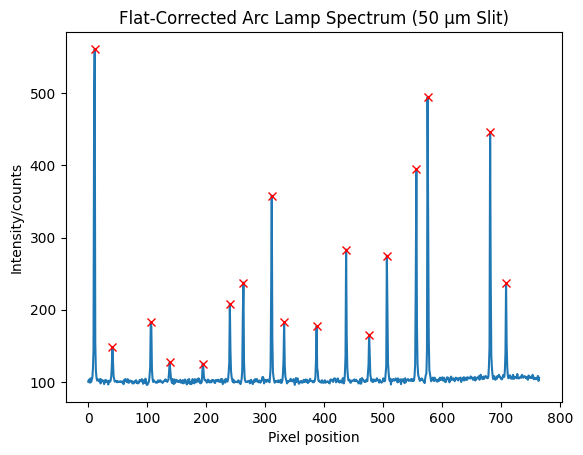

In [42]:
# 4.4.7

# Apply the normalized flat-field to the arc lamp spectrum
flat_corrected_arc = cropped_light_field_1D / normalized_flat_1d

# Plot the flat-corrected arc spectrum
plt.plot(flat_corrected_arc)

peak_idxs = find_peaks(flat_corrected_arc, height=112)
# Threshold = 6. after I tried numerous values and eventually found that only 6 can find most of the real peaks
# peak_count_vals = []
# for peak_idx in peak_idxs:
#     peak_count_vals.append(flat_corrected_arc[peak_idx])
# peak_count_vals = np.array(peak_count_vals)

print("Length of the spectrum covered by the spectrograph:",len(flat_corrected_arc),'nm')

plt.plot(peak_idxs[0],flat_corrected_arc[peak_idxs[0]], 'rx' )

plt.title('Flat-Corrected Arc Lamp Spectrum (50 µm Slit)')
plt.xlabel('Pixel position')
plt.ylabel('Intensity/counts')
plt.show()

The code above calculates the length of the spectrum covered by the spectrograph, in unit of nanometers.

In [40]:
dispersion=range*10/len(flat_corrected_arc)
print("The dispersion of the spectrograph is around",dispersion,"Angstroms per pixel")

The dispersion of the spectrograph is around 0.9726100515925793 Angstroms per pixel


 The dispersion, representing the wavelength resolution per pixel, is determined by dividing the wavelength range by the number of pixels in the flat-corrected arc spectrum, which is about 0.97 Angstroms per pixel.